In [1]:
from pylab import *
import random_idx
from __future__ import division
import scipy
import time

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})


height has been deprecated.

2016-08-25 13:43


# Hypervector Capacity with Noise

In these experiments, we are testing how noise affects the capacity of the hypervector. I derived the capacity limits based on the theory as before, and consider noise in several different conditions:

1. Gaussian noise added to the dereferencing vector
2. Gaussian noise added to the vector being added to the memory
3. Bitflip noise

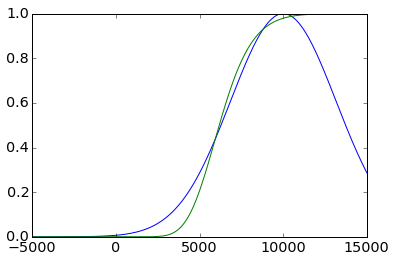

In [21]:
N = 10000
M = 1000
D = 27

x = linspace(-3*N, 3*N, 5000)

h_pdf = exp(-((x-N)**2/(2*N*(M-1))))
r_pdf = exp(-(x**2/(2*N*M)))
r_cdf = cumsum(r_pdf)

plot(x, h_pdf)
plot(x, (r_cdf/max(r_cdf))**D)

xlim([-5000, 15000])
ax = gca()
#ax.set_yticks([])

## Noise theory

The theory derived is quite simple. The variance of the Gaussian noise is simply added to the variance of the Gaussian caused by interference. 

In [2]:
def ncdf(z):
    return 0.5 * (1 + scipy.special.erf(z/2**0.5))

def p_correct_noise(M, N=10000, D=27, noise_std=0.1, ares=2000):
    
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(N - 8 * (N*Mval)**0.5, N + 8 * (N*Mval)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N + noise_std**2 * N * Mval)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N + noise_std**2 * N * Mval)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N + noise_std**2 * N * Mval)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

### Derivation

Lets consider the case where there is no noise in the superposition of the memories, but there is noise in the dereferencing hypervector. We characterize this noise as i.i.d Gaussian with mean 0 and variance $\sigma_\eta^2$. This gives us the hit distribution as the approximate sum of gaussians:

\begin{equation}
\begin{split}
\mathcal{H}_\eta &:= (X_{\ell_m}+noise) \rho^{-m} (\Psi) = (X_{\ell_m} + noise) \cdot \left[ X_{\ell_m} + \sum_{\mu \ne m}^M \rho^{\mu-m} (X_{\ell_\mu}) \right] \\
&= N + \mathcal{N}(0, N(M-1)) + \mathcal{N}(0, MN \sigma^2_\eta) \\
&= \mathcal{N}(N, N (M-1) + N M \sigma^2_\eta )
\end{split}
\end{equation}

and similarly the reject distribution is given by:

\begin{equation}
\begin{split}
\mathcal{R}_\eta &:= (X_{\ell^*}+noise) \rho^{-m} (\Psi) = (X_{\ell^*} + noise) \cdot \left[ \sum_{\mu}^M \rho^{\mu-m} (X_{\ell_\mu}) \right] \\
&= \mathcal{N}(0, N M + N M \sigma^2_\eta )
\end{split}
\end{equation}

The probability correct is the same integral with these distributions. 

We can also see that if the noise was instead like a bit-flip, with the probability of bit-flip, $p_{flip}$, then this will have a conversion to the same distributions:

\begin{equation}
\begin{split}
\mathcal{H}_\eta &:= (X_{\ell_m}+flips) \rho^{-m} (\Psi) = (X_{\ell_m} + flips) \cdot \left[ X_{\ell_m} + \sum_{\mu \ne m}^M \rho^{\mu-m} (X_{\ell_\mu}) \right] \\
&= N - \mathcal{N} (2N p_{flip}, 2N p_{flip} ) + \mathcal{N}(0, N(M-1)) \\
&= \mathcal{N}(N - 2N p_{flip}, N (M-1) + 2N p_{flip})
\end{split}
\end{equation}

but then lets rewrite this in terms of SNR:

\begin{equation}
\mathcal{N}(N - 2N p_{flip}, N (M-1) + 2N p_{flip}) = \mathcal{N} (1, \frac{(M-1) + 2p_{flip}}{N (1 - 2p_{flip})^2}
\end{equation}

\begin{equation}
SNR_{flip} = \sqrt{\frac{N(1-2p_{flip})^2}{(M-1) + 2p_{flip}}}
\end{equation}

\begin{equation}
SNR_{\sigma} = \sqrt{\frac{N}{(M-1) + M\sigma^2_\eta}}
\end{equation}

then these are the same if:

\begin{equation}
\sigma^2_\eta(p_{flip}) = \frac{2 p_{flip} (- 2 p_{flip}(M-1) + 2 p_{flip} - 1)} {(1 - 2 p_{flip} )^2 M }
\end{equation}

which for large $M$ gives:

\begin{equation}
\lim_{M \rightarrow \infty} \sigma^2_\eta(p_{flip}) = \frac{4 p_{flip} (1 - p_{flip})}{(1-2p_{flip})^2}
\end{equation}

## Dereferencing Noise

In the first case we will consider that the dereferencing vector has noise with everything else the same. This is just adding Gaussian noise during the dereferencing step.

In [3]:
def test_capacity_noise_deref(N, D, K=5, noise_std=0.1, trials=5e3):
    '''
    Runs a capacity experiment with noise in the dereferencing vector.
    '''
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1

    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)

    for i in range(int(trials)-1):
        
        lidx[i+1] = np.random.randint(D)

        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]

        v_last_input = np.roll(hypercapacity, -1)
        v_input_K = np.roll(hypercapacity, -K) # we can still do this less than K, it will just be noise
        v_first_input = np.roll(hypercapacity, -(i+1))
        
        deref_noise = noise_std * np.random.randn(D, N)
        
        lidx_last_input[i] = argmax(np.dot(letter_vectors + deref_noise, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors + deref_noise, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors + deref_noise, v_first_input.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [30]:

test_N = [1000, 2000, 4000]

noise_std = 3.3

runs = 3

run_id = []
run_N = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

for r in range(runs):
    print r
    for N in test_N:
        lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_noise_deref(N, len(random_idx.alphabet), noise_std=noise_std)
        
        run_id.append(r)
        run_N.append(N)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
filename = 'data/capacity-noise-N=' + str(len(test_N)) + '-n' + str(noise_std) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_N=run_N, runs=runs, test_N=test_N)

0


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: Depre

Duration:  8.33362197876
Duration:  16.4791288376
Duration:  32.7255620956
1
Duration:  9.04055190086
Duration:  16.3038141727
Duration:  32.4331510067
2
Duration:  8.56543207169
Duration:  16.582365036
Duration:  32.5388031006
data/capacity-noise-N=3-n3.3-r=3-n160616.npz


In [31]:
K=5
run_id = np.array(run_id)
run_N = np.array(run_N)

uN = unique(run_N)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uN)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uN)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uN)))

for iN, idxN in enumerate(uN):
    idxs = find(run_N==idxN)
    for i in idxs:
        li_mean[:,iN] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,iN] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')  
        fi_mean[:,iN] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


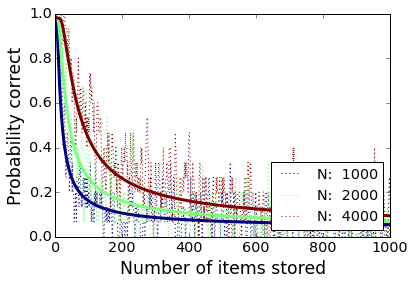

In [39]:
figure(figsize=(6,4))
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), 
         ':', color=cm(i), lw=1, label="N: %5i" % test_N[i])


M = np.arange(li_mean.shape[0])

for idxN,N in enumerate(test_N):
    p_correct = p_correct_noise(M, N=N, D=len(random_idx.alphabet), noise_std=noise_std)
    plot(M, p_correct, color=cm(idxN),lw=3)


legend(loc='lower right');
#title('Readout of most recent input', fontsize=20);
xlabel('Number of items stored');
ylabel('Probability correct')

xlim([0,1000])
savefig('figures/capacity_deref_noise-noise_theory-n=' + str(noise_std) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity_defef_noise-noise_theory-n=' + str(noise_std) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

**Figure: Noise in dereferencing vector.** Noise was added to the dereferencing vector. Empirical evalutation of readout probability plotted in dashed lines, thoery in solid lines.


In [43]:
K=5
N = 1000
test_noise = [0.5, 1, 1.5, 2, 3, 4]

runs = 5

run_id = []
run_noise = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

for r in range(runs):
    print r
    for noise_std in test_noise:
        lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_noise_deref(N, len(random_idx.alphabet), K=K, noise_std=noise_std)
        
        run_id.append(r)
        run_noise.append(noise_std)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
filename = 'data/capacity-noise-N=' + str(N) + '-tn=' + str(len(test_noise)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all, K=K,
        run_id=run_id, run_noise=run_noise, runs=runs, N=N, D=len(random_idx.alphabet), test_noise=test_noise)

0


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: Depre

Duration:  8.61265707016
Duration:  8.62074995041
Duration:  8.49289107323
Duration:  8.52609682083
Duration:  8.5038819313
Duration:  8.57317590714
1
Duration:  8.62782692909
Duration:  8.57065200806
Duration:  8.41189694405
Duration:  8.54581308365
Duration:  8.47345089912
Duration:  8.46197986603
2
Duration:  8.44725394249
Duration:  8.3896279335
Duration:  8.39950013161
Duration:  8.56921887398
Duration:  8.39985513687
Duration:  8.56606912613
3
Duration:  8.51421904564
Duration:  8.43542289734
Duration:  8.5680270195
Duration:  8.4877948761
Duration:  8.45594882965
Duration:  8.57256913185
4
Duration:  8.53311014175
Duration:  8.64886689186
Duration:  8.46949887276
Duration:  8.43472504616
Duration:  8.5331659317
Duration:  8.48570895195


TypeError: object of type 'int' has no len()

In [46]:
K=5
run_id = np.array(run_id)
run_noise = np.array(run_noise)

unoise = unique(run_noise)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(unoise)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(unoise)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(unoise)))

for idx_noise, noise_std in enumerate(unoise):
    idxs = find(run_noise==noise_std)
    for i in idxs:
        li_mean[:,idx_noise] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,idx_noise] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')  
        fi_mean[:,idx_noise] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


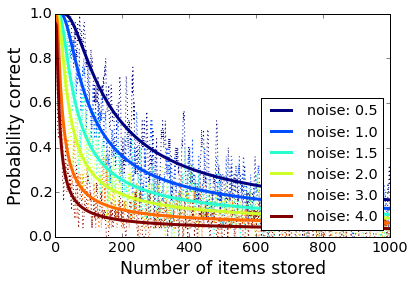

In [51]:
figure(figsize=(6,4))
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), 
         ':', color=cm(i), lw=1)


M = np.arange(li_mean.shape[0])

for idx_noise,noise_std in enumerate(test_noise):
    p_correct = p_correct_noise(M, N=N, D=len(random_idx.alphabet), noise_std=noise_std)
    plot(M, p_correct, color=cm(idx_noise),lw=3, label="noise: %1.1f" % noise_std)


legend(loc='lower right');
#title('Readout of most recent input', fontsize=20);
xlabel('Number of items stored');
ylabel('Probability correct')

xlim([0,1000])
savefig('figures/capacity_deref_noise-noise_theory-tn=' + str(len(test_noise)) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity_defef_noise-noise_theory-tn=' + str(len(test_noise)) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

**Figure: Noise in dereferencing vector.** Noise was added to the dereferencing vector. Empirical evalutation of readout probability plotted in dashed lines, thoery in solid lines.


## Noise in the accumulation

The next thing to consider is that the vectors being added to memory each contain noise. At first, I thought that this would mean that the noise would build up, and that the same noise variance in the accumulation would be worse than noise variance in the dereference. However, the math works out the same, and so does the empirical simulation.

This is actually faster to simulate empirically, because only make 1 noise vector per item, instead of D noise vectors during the dereference.

In [56]:
def test_capacity_noise_accum(N, D, K=5, noise_std=0.1, trials=5e3):
    '''
    Runs capacity experiment with noise added with each memory item.
    '''
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1

    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)

    for i in range(int(trials)-1):
        
        lidx[i+1] = np.random.randint(D)

        
        accum_noise = noise_std * np.random.randn(N)
        
        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :] + accum_noise

        v_last_input = np.roll(hypercapacity, -1)
        v_input_K = np.roll(hypercapacity, -K) # we can still do this less than K, it will just be noise
        v_first_input = np.roll(hypercapacity, -(i+1))
        
        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [61]:
K=5
N = 10000
test_noise = [0.1, 0.5, 1, 2, 3, 4]

runs = 5

run_id = []
run_noise = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

for r in range(runs):
    print r
    for noise_std in test_noise:
        lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_noise_accum(N, len(random_idx.alphabet), K=K, noise_std=noise_std)
        
        run_id.append(r)
        run_noise.append(noise_std)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
filename = 'data/capacity-accum_noise-N=' + str(N) + '-tn=' + str(len(test_noise)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all, K=K,
        run_id=run_id, run_noise=run_noise, runs=runs, N=N, D=len(random_idx.alphabet), test_noise=test_noise)

0


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: Dep

Duration:  10.479804039
Duration:  11.1641027927
Duration:  11.2026431561
Duration:  11.3017089367
Duration:  11.8092648983
Duration:  11.0526428223
1
Duration:  11.5029358864
Duration:  11.1284601688
Duration:  10.4890069962
Duration:  11.8626379967
Duration:  11.5044119358
Duration:  11.583081007
2
Duration:  10.6273970604
Duration:  11.1743688583
Duration:  11.2646028996
Duration:  11.0433309078
Duration:  10.9761328697
Duration:  11.4457027912
3
Duration:  10.6524970531
Duration:  11.1040110588
Duration:  10.3675510883
Duration:  10.425360918
Duration:  9.94043111801
Duration:  10.3350989819
4
Duration:  9.80643081665
Duration:  10.299131155
Duration:  10.1498529911
Duration:  9.84593200684
Duration:  10.7870140076
Duration:  10.2431077957
data/capacity-accum_noise-N=10000-tn=6-r=5-n160616.npz


In [7]:
#h = np.load('data/hypervector_capacity_decay-d=0.998-N=1-D=3-r=5-n160518.npz')
h = np.load('data/capacity-accum_noise-N=10000-tn=6-r=5-n160616.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']
run_id = h['run_id']
run_noise = h['run_noise']
test_noise = h['test_noise']
runs = h['runs']
N = h['N']
D = h['D']
#K = h['K']

In [8]:
K=5
run_id = np.array(run_id)
run_noise = np.array(run_noise)

unoise = unique(run_noise)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(unoise)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(unoise)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(unoise)))

for idx_noise, noise_std in enumerate(unoise):
    idxs = find(run_noise==noise_std)
    for i in idxs:
        li_mean[:,idx_noise] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,idx_noise] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')  
        fi_mean[:,idx_noise] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


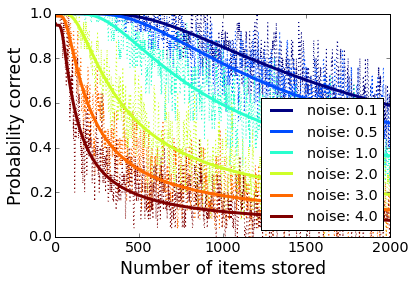

In [9]:
figure(figsize=(6,4))
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), 
         ':', color=cm(i), lw=1)


M = np.arange(li_mean.shape[0])

for idx_noise,noise_std in enumerate(test_noise):
    p_correct = p_correct_noise(M, N=N, D=len(random_idx.alphabet), noise_std=noise_std)
    plot(M, p_correct, color=cm(idx_noise),lw=3, label="noise: %1.1f" % noise_std)


legend(loc='lower right');
#title('Readout of most recent input', fontsize=20);
xlabel('Number of items stored');
ylabel('Probability correct')

xlim([0,2000])
savefig('figures/capacity_accum_noise-noise_theory-tn=' + str(len(test_noise)) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity_accum_noise-noise_theory-tn=' + str(len(test_noise)) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

**Figure: Noise in memory items.** Noise was added to each memory item as it is being stored. Empirical evalutation of readout probability plotted in dashed lines, thoery in solid lines.


## Noise as bitflips

Instead of Guassian white noise being added to the vectors, in this scenario we consider a small probability that the bits in the vector flip, $p_{flip}$. 


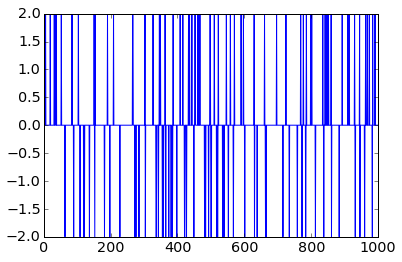

In [87]:
D=27
N=1000
p_flip = 0.1

letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1
lv = letter_vectors[1,:].copy() # copy is important or it doesn't work correctly.
flip_idx = np.random.rand(N) < p_flip

lv[flip_idx] = -lv[flip_idx]

plot(letter_vectors[1,:] - lv)

In [86]:
def test_capacity_noise_bitflip(N, D, K=5, p_flip=0.1, trials=5e3):
    '''
    Runs a capacity experiment with noise in the dereferencing vector.
    '''
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1

    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)
    
    for i in range(int(trials)-1):
        
        lidx[i+1] = np.random.randint(D)
        lv =  letter_vectors[lidx[i+1], :].copy()
        flip_idx = np.random.rand(N) < p_flip
        lv[flip_idx] = -lv[flip_idx]
        
        hypercapacity = np.roll(hypercapacity, 1) + lv

        v_last_input = np.roll(hypercapacity, -1)
        v_input_K = np.roll(hypercapacity, -K) # we can still do this less than K, it will just be noise
        v_first_input = np.roll(hypercapacity, -(i+1))

        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [93]:
K=5
N = 10000
test_p_flip = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32]

runs = 5

run_id = []
run_noise = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

for r in range(runs):
    print r
    for p_flip in test_p_flip:
        lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_noise_bitflip(N, len(random_idx.alphabet), K=K, p_flip=p_flip)
        
        run_id.append(r)
        run_noise.append(p_flip)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
filename = 'data/capacity-bitflip_noise-N=' + str(N) + '-tn=' + str(len(test_noise)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all, K=K,
        run_id=run_id, run_noise=run_noise, runs=runs, N=N, D=len(random_idx.alphabet), test_p_flip=test_p_flip)

0


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: Dep

Duration:  4.45145392418
Duration:  4.33689284325
Duration:  4.19571900368
Duration:  4.45385909081
Duration:  4.63820099831
Duration:  4.91682505608
1
Duration:  4.56908202171
Duration:  4.24916410446
Duration:  4.37124180794
Duration:  4.48309779167
Duration:  4.59223604202
Duration:  4.8548951149
2
Duration:  4.5387430191
Duration:  4.47112512589
Duration:  4.26083993912
Duration:  4.38766098022
Duration:  4.65188717842
Duration:  4.71929383278
3
Duration:  4.09749102592
Duration:  4.35897612572
Duration:  4.30993080139
Duration:  4.51436090469
Duration:  4.53281283379
Duration:  4.93940281868
4
Duration:  4.13553118706
Duration:  4.22938299179
Duration:  4.28617691994
Duration:  4.35388994217
Duration:  4.49080109596
Duration:  4.75417804718
data/capacity-bitflip_noise-N=10000-tn=6-r=5-n160616.npz


In [94]:
K=5
run_id = np.array(run_id)
run_noise = np.array(run_noise)

unoise = unique(run_noise)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(unoise)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(unoise)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(unoise)))

for idx_noise, p_flip in enumerate(unoise):
    idxs = find(run_noise==p_flip)
    for i in idxs:
        li_mean[:,idx_noise] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,idx_noise] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')  
        fi_mean[:,idx_noise] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


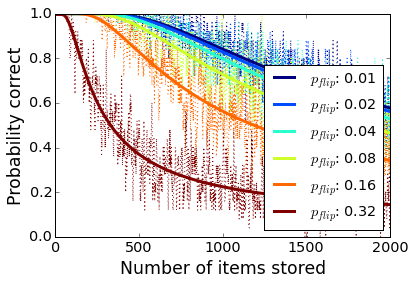

In [101]:
figure(figsize=(6,4))
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), 
         ':', color=cm(i), lw=1)


M = np.arange(li_mean.shape[0])

for idx_noise, p_flip in enumerate(test_p_flip):
    noise_var = 4 * p_flip * (1 - p_flip) / (1-2*p_flip)**2
    p_correct = p_correct_dnoise(M, N=N, D=len(random_idx.alphabet), noise_std=noise_var**0.5)
    plot(M, p_correct, color=cm(idx_noise),lw=3, label="$p_{flip}$: %0.2f" % p_flip)


legend(loc='lower right');
#title('Readout of most recent input', fontsize=20);
xlabel('Number of items stored');
ylabel('Probability correct')

xlim([0,2000])
savefig('figures/capacity_bitflip_noise-noise_theory-N=' + str(N) +'-tn=' + str(len(test_noise)) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity_bitflip_noise-noise_theory-N='+ str(N) + '-tn=' + str(len(test_noise)) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

**Figure: Bitflip noise in memory items.** The bits representing each memory item were randomly flipped with probability $p_{flip}$ when added to the memory. Empirical evalutation of readout probability plotted in dashed lines, thoery in solid lines.

Here the same theory equation can be used again, because there is a direct relationship with the noise variance and the probability of bit flip. This is given by:

$$
\sigma^2_{\eta} = \frac{4 p_{flip} (1 - p_{flip})}{(1 - 2 p_{flip}) ^ 2}
$$

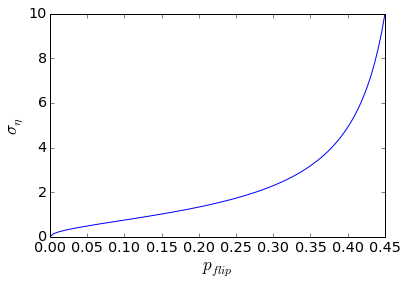

In [99]:
figure(figsize=(6,4))

p_flip = np.linspace(0, 0.45, 100)

noise_std = np.sqrt( 4 * p_flip * (1 - p_flip) / (1 - 2 * p_flip) ** 2)

plot(p_flip, noise_std)
xlabel('$p_{flip}$')
ylabel('$\sigma_\eta$')

**Figure: Theoretical relationship between bitflip noise and additive Gaussian noise.**